# 目錄
## ．放入融資融券
### ．．．測試預測幾天後的成效最好（看起來是8天）
### ．．．建立 rolling models
## ．畫Y999股價搭配牛熊顏色的圖
## ．加入其他基本因子
## ．加入新聞輿情與熱度
### ．．．正規化全部因子
## ．加入更多因子
## ．使用不同演算法：logistic regression, naive bayes, SVM
### ．．．logistic regression 進行 feature selections
## ．進行RF feature selections （使用SelectFromModel, RFECV）

# Read in label dataframe

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

Fontconfig warning: ignoring UTF-8: not a valid region tag


In [2]:
label = pd.read_csv('algoDefLabel.csv')
label['bb'] = label['algoDefine'].apply(lambda x: int(x))

In [3]:
margin = pd.read_csv('./index_data/margin_20050103_20220511.csv', encoding='big5')

In [4]:
filtered_margin = margin[['年月日', '融資餘額(張)', '融資餘額(千元)', '融券餘額(張)', '融券餘額(千元)', '借券賣出餘額(張)', '借券賣出餘額(千元)', '借券賣出可使用額度', '借券賣出限額', '券資比']]

In [5]:
# for i in margin.columns:
#     print(i, end='  ')

公司代碼  簡稱  年月日  

#### 融資餘額(張)  融資餘額(千元)  
    融資買進(張)  融資買進(千元)  
    融資賣出(張)  融資賣出(千元)  
    融資現金償還(張)  融資現金償還(千元)  
    融資增減(張)  融資增減(千元)  融資增減比率  
    融資使用率  融資限額  

#### 融券餘額(張)  融券餘額(千元)  
    融券買進(張)  融券買進(千元)  
    融券賣出(張)  融券賣出(千元)  
    融券現券償還(張)  融券現券償還(千元)  
    融券增減(張)  融券增減(千元)  融券增減比率  
    融券使用率  融券限額  

是否可信用交易(Y)  #### 券資比  資券互抵  當日收盤  

融資(買+賣)/成交量 %  融券(買+賣)/成交量 %  

#### 借券賣出餘額(張)  借券賣出餘額(千元)  
    借券賣出(張)  借券賣出(千元)  
    借券賣出庫存異動(張)  借券賣出庫存異動(千元)  
    #### 借券賣出可使用額度  借券賣出限額  
    借券賣出(千元)_交易所  融券賣出(千元)_交易所  

均價  
每股融資成本  每股融券成本  
融資維持率  融券維持率  整戶維持率  

#### CPI總指數

In [6]:
df = filtered_margin.merge(label[['Date', 'close_adj', 'bb']], left_on='年月日', right_on='Date')

In [7]:
df

,年月日,融資餘額(張),融資餘額(千元),融券餘額(張),融券餘額(千元),借券賣出餘額(張),借券賣出餘額(千元),借券賣出可使用額度,借券賣出限額,券資比,Date,close_adj,bb
0,2008/01/02,17416413,330226419.0,446743,22386158.26,941766,40182569.36,15829848,52766131,2.57,2008/01/02,9845.42,0
1,2008/01/03,17457081,332032980.0,431996,20588767.58,943067,38679629.96,15820023,52733376,2.47,2008/01/03,9681.17,0
2,2008/01/04,17515892,334346118.0,448848,20666002.95,933568,38116807.14,15815849,52719469,2.56,2008/01/04,9724.82,0
3,2008/01/07,17446380,333416251.0,430747,19149243.61,938141,36351105.52,15816449,52721469,2.47,2008/01/07,9325.32,0
4,2008/01/08,17459758,333013941.0,451952,19760438.32,948282,36230978.44,16106439,53688104,2.59,2008/01/08,9419.41,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3530,2022/05/04,8483629,252497763.0,388583,22595578.84,10974527,531024203.68,1341851,76197874,4.58,2022/05/04,32947.47,0
3531,2022/05/05,8518787,253143450.0,398061,23445108.11,10906950,535959494.53,1337917,76205474,4.67,2022/05/05,33206.59,0
3532,2022/05/06,8506707,253016723.0,390208,22495883.07,10824940,523467852.96,1338743,76234516,4.59,2022/05/06,32633.97,0
3533,2022/05/09,8390725,250125870.0,392470,21799703.83,10948167,519945004.74,1338754,76251750,4.68,2022/05/09,31919.41,0


# Random Forest Example

### n_classes(4) * n_clusters_per_class(2) must be smaller or equal 2**n_informative(2)=4

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
# X, y = make_classification(n_samples=1000, n_features=4, n_informative=2, n_redundant=0, random_state=0, shuffle=False)
X, y = make_classification(n_samples=1000, n_features=20, n_classes=4, n_informative=4, shuffle=True)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)

print(clf.predict([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

[2]


In [9]:
X.shape

(1000, 20)

In [10]:
y.shape

(1000,)

# Start Training

In [11]:
df[df['年月日'] < '2021/01/01']

,年月日,融資餘額(張),融資餘額(千元),融券餘額(張),融券餘額(千元),借券賣出餘額(張),借券賣出餘額(千元),借券賣出可使用額度,借券賣出限額,券資比,Date,close_adj,bb
0,2008/01/02,17416413,330226419.0,446743,22386158.26,941766,40182569.36,15829848,52766131,2.57,2008/01/02,9845.42,0
1,2008/01/03,17457081,332032980.0,431996,20588767.58,943067,38679629.96,15820023,52733376,2.47,2008/01/03,9681.17,0
2,2008/01/04,17515892,334346118.0,448848,20666002.95,933568,38116807.14,15815849,52719469,2.56,2008/01/04,9724.82,0
3,2008/01/07,17446380,333416251.0,430747,19149243.61,938141,36351105.52,15816449,52721469,2.47,2008/01/07,9325.32,0
4,2008/01/08,17459758,333013941.0,451952,19760438.32,948282,36230978.44,16106439,53688104,2.59,2008/01/08,9419.41,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3205,2020/12/25,8745028,184261341.0,1163281,27977389.83,8162513,329407523.66,1792119,72503262,13.30,2020/12/25,27667.00,1
3206,2020/12/28,8868468,186790038.0,1197623,29302775.94,8221767,333830873.72,1810826,72498309,13.50,2020/12/28,27959.77,1
3207,2020/12/29,8777489,185949806.0,1185802,28971069.69,8234700,334385107.12,1836023,72502998,13.51,2020/12/29,27938.50,1
3208,2020/12/30,8842775,187131498.0,1176219,29232796.17,8249918,335615679.12,1854665,72501128,13.30,2020/12/30,28354.81,1


In [12]:
from sklearn.metrics import confusion_matrix

split = 3210
delay = 5

print((df.iloc[:, 1:-3].values).shape)
print((df.iloc[:, -1].values).shape)
X = df.iloc[:-delay, 1:-3].values
y = df.iloc[delay:, -1].values
X_train = df.iloc[:split-delay, 1:-3].values
y_train = df.iloc[delay:split, -1].values
X_test = df.iloc[split-delay:-delay, 1:-3].values
y_test = df.iloc[split:, -1].values
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3535, 9)
(3535,)
(3205, 9) (3205,) (325, 9) (325,)


In [13]:
clf = RandomForestClassifier()

for epoch in range(10):
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    confusionMatrix = confusion_matrix(y_test, y_predict)
    print(confusionMatrix)
    accuracy = (confusionMatrix[0, 0]+confusionMatrix [1,1])/sum(sum(confusionMatrix))
    print(accuracy)

[[ 19  26]
 [ 15 265]]
0.8738461538461538
[[  0  45]
 [  2 278]]
0.8553846153846154
[[  4  41]
 [  8 272]]
0.8492307692307692
[[ 18  27]
 [ 12 268]]
0.88
[[  6  39]
 [  3 277]]
0.8707692307692307
[[  3  42]
 [  2 278]]
0.8646153846153846
[[  2  43]
 [  4 276]]
0.8553846153846154
[[  1  44]
 [  0 280]]
0.8646153846153846
[[ 10  35]
 [ 11 269]]
0.8584615384615385
[[ 10  35]
 [  2 278]]
0.8861538461538462


# 測試看看預測幾天後的準確率比較高

In [205]:
for delay in range(1, 20):
    split = 3210
    X = df.iloc[:-delay, 1:-3].values
    y = df.iloc[delay:, -1].values
    X_train = df.iloc[:split-delay, 1:-3].values
    y_train = df.iloc[delay:split, -1].values
    X_test = df.iloc[split-delay:-delay, 1:-3].values
    y_test = df.iloc[split:, -1].values
    
    clf = RandomForestClassifier()
    
    accuracy_list = []
    
    for epoch in range(10):
        clf.fit(X_train, y_train)
        y_predict = clf.predict(X_test)
        confusionMatrix = confusion_matrix(y_test, y_predict)
#         print(confusionMatrix)
        accuracy = (confusionMatrix[0, 0]+confusionMatrix [1,1])/sum(sum(confusionMatrix))
#         print(accuracy)
        accuracy_list.append(accuracy)
    print('Delay: ', delay, 'Average Accuracy: ', sum(accuracy_list)/len(accuracy_list))

Delay:  1 Average Accuracy:  0.8615384615384615
Delay:  2 Average Accuracy:  0.8624615384615385
Delay:  3 Average Accuracy:  0.8630769230769231
Delay:  4 Average Accuracy:  0.858153846153846
Delay:  5 Average Accuracy:  0.8695384615384615
Delay:  6 Average Accuracy:  0.8710769230769231
Delay:  7 Average Accuracy:  0.9043076923076925
Delay:  8 Average Accuracy:  0.9049230769230769
Delay:  9 Average Accuracy:  0.9015384615384615
Delay:  10 Average Accuracy:  0.8280000000000001
Delay:  11 Average Accuracy:  0.7886153846153846
Delay:  12 Average Accuracy:  0.7227692307692307
Delay:  13 Average Accuracy:  0.7319999999999999
Delay:  14 Average Accuracy:  0.644
Delay:  15 Average Accuracy:  0.6966153846153845
Delay:  16 Average Accuracy:  0.696
Delay:  17 Average Accuracy:  0.6104615384615385
Delay:  18 Average Accuracy:  0.7553846153846153
Delay:  19 Average Accuracy:  0.7409230769230769


In [206]:
for delay in range(1, 30):
    split = 3210
    X = df.iloc[:-delay, 1:-3].values
    y = df.iloc[delay:, -1].values
    X_train = df.iloc[:split-delay, 1:-3].values
    y_train = df.iloc[delay:split, -1].values
    X_test = df.iloc[split-delay:-delay, 1:-3].values
    y_test = df.iloc[split:, -1].values
    
    clf = RandomForestClassifier()
    
    accuracy_list = []
    
    for epoch in range(10):
        clf.fit(X_train, y_train)
        y_predict = clf.predict(X_test)
        confusionMatrix = confusion_matrix(y_test, y_predict)
#         print(confusionMatrix)
        accuracy = (confusionMatrix[0, 0]+confusionMatrix [1,1])/sum(sum(confusionMatrix))
#         print(accuracy)
        accuracy_list.append(accuracy)
    print('Delay: ', delay, 'Average Accuracy: ', sum(accuracy_list)/len(accuracy_list))

Delay:  1 Average Accuracy:  0.8655384615384616
Delay:  2 Average Accuracy:  0.8587692307692307
Delay:  3 Average Accuracy:  0.8630769230769231
Delay:  4 Average Accuracy:  0.8541538461538462
Delay:  5 Average Accuracy:  0.8655384615384614
Delay:  6 Average Accuracy:  0.8756923076923077
Delay:  7 Average Accuracy:  0.8987692307692308
Delay:  8 Average Accuracy:  0.9083076923076921
Delay:  9 Average Accuracy:  0.8941538461538461
Delay:  10 Average Accuracy:  0.8689230769230768
Delay:  11 Average Accuracy:  0.8295384615384617
Delay:  12 Average Accuracy:  0.7787692307692308
Delay:  13 Average Accuracy:  0.6636923076923077
Delay:  14 Average Accuracy:  0.7052307692307693
Delay:  15 Average Accuracy:  0.7735384615384615
Delay:  16 Average Accuracy:  0.5553846153846155
Delay:  17 Average Accuracy:  0.547076923076923
Delay:  18 Average Accuracy:  0.7270769230769231
Delay:  19 Average Accuracy:  0.7726153846153846
Delay:  20 Average Accuracy:  0.7778461538461537
Delay:  21 Average Accuracy:  

### 看起來是8天

In [207]:
for delay in range(8, 9):
    split = 3210
    X = df.iloc[:-delay, 1:-3].values
    y = df.iloc[delay:, -1].values
    X_train = df.iloc[:split-delay, 1:-3].values
    y_train = df.iloc[delay:split, -1].values
    X_test = df.iloc[split-delay:-delay, 1:-3].values
    y_test = df.iloc[split:, -1].values
    
    clf = RandomForestClassifier()
    
    accuracy_list = []
    
    for epoch in range(10):
        clf.fit(X_train, y_train)
        y_predict = clf.predict(X_test)
        confusionMatrix = confusion_matrix(y_test, y_predict)
#         print(confusionMatrix)
        accuracy = (confusionMatrix[0, 0]+confusionMatrix [1,1])/sum(sum(confusionMatrix))
#         print(accuracy)
        accuracy_list.append(accuracy)
    print('Delay: ', delay, 'Average Accuracy: ', sum(accuracy_list)/len(accuracy_list))

Delay:  8 Average Accuracy:  0.9012307692307694


# 建立 rolling models & predictions

In [216]:
clf1 = RandomForestClassifier()
clf5 = RandomForestClassifier()
clf10 = RandomForestClassifier()
clf15 = RandomForestClassifier()
clf20 = RandomForestClassifier()

for year in range(2010, 2022):
    
    split = df[df['年月日'] < str(year)+'/01/01'].shape[0] # 3210
    end = df[df['年月日'] < str(year+1)+'/01/01'].shape[0] 
    
    for delay in [1, 5, 10, 15, 20]:
        
        if delay == 1:
            clf = clf1
        elif delay == 5:
            clf = clf5
        elif delay == 10:
            clf = clf10
        elif delay == 15:
            clf = clf15
        elif delay == 20:
            clf = clf20
            

        X_train = df.iloc[:split-delay, 1:-3].values
        y_train = df.iloc[delay:split, -1].values
        X_test = df.iloc[split-delay:end-delay, 1:-3].values
        y_test = df.iloc[split:end, -1].values

#         print('\n', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        print('\n')

        accuracy_list = []

        for epoch in range(10):
            clf.fit(X_train, y_train)
            y_predict = clf.predict(X_test)
            confusionMatrix = confusion_matrix(y_test, y_predict)
    #         print(confusionMatrix)
            accuracy = (confusionMatrix[0, 0]+confusionMatrix [1,1])/sum(sum(confusionMatrix))
    #         print(accuracy)
            accuracy_list.append(accuracy)
        print('Year: ', year, 'Delay: ', delay, 'Average Accuracy: ', sum(accuracy_list)/len(accuracy_list))
    


 (499, 9) (499,) (251, 9) (251,)
Year:  2010 Delay:  1 Average Accuracy:  0.9231075697211155

 (495, 9) (495,) (251, 9) (251,)
Year:  2010 Delay:  5 Average Accuracy:  0.9274900398406374

 (490, 9) (490,) (251, 9) (251,)
Year:  2010 Delay:  10 Average Accuracy:  0.7310756972111555

 (485, 9) (485,) (251, 9) (251,)
Year:  2010 Delay:  15 Average Accuracy:  0.4055776892430279

 (480, 9) (480,) (251, 9) (251,)
Year:  2010 Delay:  20 Average Accuracy:  0.9007968127490038

 (750, 9) (750,) (247, 9) (247,)
Year:  2011 Delay:  1 Average Accuracy:  0.08097165991902834

 (746, 9) (746,) (247, 9) (247,)
Year:  2011 Delay:  5 Average Accuracy:  0.08259109311740889

 (741, 9) (741,) (247, 9) (247,)
Year:  2011 Delay:  10 Average Accuracy:  0.08380566801619432

 (736, 9) (736,) (247, 9) (247,)
Year:  2011 Delay:  15 Average Accuracy:  0.08178137651821862

 (731, 9) (731,) (247, 9) (247,)
Year:  2011 Delay:  20 Average Accuracy:  0.08097165991902834

 (997, 9) (997,) (250, 9) (250,)
Year:  2012 Del

Good Performance (10 days delay: 70% up) : 10, 13, 14, 20, 21

Not Bad (10 days delay: 30% up, about 50%) : 17, 18

Bad Performance (10 days delay: 30% down) : 11, 12, 15, 16, 19

In [275]:
clf1 = RandomForestClassifier()
clf5 = RandomForestClassifier()
clf10 = RandomForestClassifier()
clf15 = RandomForestClassifier()
clf20 = RandomForestClassifier()

for year in range(2010, 2023):
    
    split = df[df['年月日'] < str(year)+'/01/01'].shape[0] # 3210
    start = df[df['年月日'] < str(year-1)+'/01/01'].shape[0] # 3210
    end = df[df['年月日'] < str(year+1)+'/01/01'].shape[0] 
    
    for delay in [1, 5, 10, 15, 20]:
        
        if delay == 1:
            clf = clf1
        elif delay == 5:
            clf = clf5
        elif delay == 10:
            clf = clf10
        elif delay == 15:
            clf = clf15
        elif delay == 20:
            clf = clf20
            

        X_train = df.iloc[:split-delay, 1:-3].values
        y_train = df.iloc[delay:split, -1].values
        X_test = df.iloc[split-delay:end-delay, 1:-3].values
        y_test = df.iloc[split:end, -1].values

        print('\n', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
#         print('\n')

        accuracy_list = []

        for epoch in range(10):
            clf.fit(X_train, y_train)
            y_predict = clf.predict(X_test)
            confusionMatrix = confusion_matrix(y_test, y_predict)
    #         print(confusionMatrix)
            accuracy = (confusionMatrix[0, 0]+confusionMatrix [1,1])/sum(sum(confusionMatrix))
    #         print(accuracy)
            accuracy_list.append(accuracy)
        print('Year: ', year, 'Delay: ', delay, 'Average Accuracy: ', sum(accuracy_list)/len(accuracy_list))
    


 (499, 9) (499,) (251, 9) (251,)
Year:  2010 Delay:  1 Average Accuracy:  0.9258964143426294

 (495, 9) (495,) (251, 9) (251,)
Year:  2010 Delay:  5 Average Accuracy:  0.9131474103585656

 (490, 9) (490,) (251, 9) (251,)
Year:  2010 Delay:  10 Average Accuracy:  0.6685258964143427

 (485, 9) (485,) (251, 9) (251,)
Year:  2010 Delay:  15 Average Accuracy:  0.38247011952191234

 (480, 9) (480,) (251, 9) (251,)
Year:  2010 Delay:  20 Average Accuracy:  0.894820717131474

 (750, 9) (750,) (247, 9) (247,)
Year:  2011 Delay:  1 Average Accuracy:  0.08097165991902834

 (746, 9) (746,) (247, 9) (247,)
Year:  2011 Delay:  5 Average Accuracy:  0.0825910931174089

 (741, 9) (741,) (247, 9) (247,)
Year:  2011 Delay:  10 Average Accuracy:  0.08461538461538462

 (736, 9) (736,) (247, 9) (247,)
Year:  2011 Delay:  15 Average Accuracy:  0.08259109311740889

 (731, 9) (731,) (247, 9) (247,)
Year:  2011 Delay:  20 Average Accuracy:  0.08097165991902834

 (997, 9) (997,) (250, 9) (250,)
Year:  2012 Dela

# 畫圖

In [14]:
def drawBullLabel(dailyLabel):
    if dailyLabel[1] == True:
        return dailyLabel[0]
    else:
        return float('nan')
    
def drawBearLabel(dailyLabel):
    if dailyLabel[1] == False:
        return dailyLabel[0]
    else:
        return float('nan')

drawBull = label[['close_adj', 'algoDefine']].apply(lambda x: drawBullLabel(x), axis=1)
drawBear = label[['close_adj', 'algoDefine']].apply(lambda x: drawBearLabel(x), axis=1)

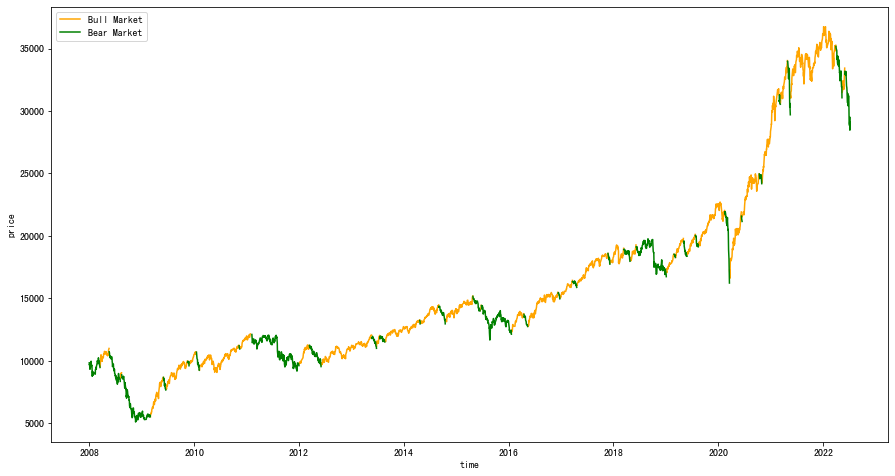

In [15]:
import matplotlib.pyplot as plt

%matplotlib inline
fig = plt.figure(figsize=(15,8))
# fig = plt.figure()
ax = plt.axes()

# for i in label.index:
ax.plot(pd.to_datetime(label.Date), drawBull, label='Bull Market', color='orange')
ax.plot(pd.to_datetime(label.Date), drawBear, label='Bear Market', color='green')

ax.set_xlabel('time')  # Add an x-label to the axes.
ax.set_ylabel('price')  # Add a y-label to the axes.
ax.legend();  # Add a legend.

In [181]:
label.loc[label['Date']>='2015/01/22', :]

,X,Date,close_adj,volume,algoDefine,bb
1756,1755,2015/01/22,14267.19,5782452,True,1
1757,1756,2015/01/23,14421.64,6246155,True,1
1758,1757,2015/01/26,14431.89,4902892,True,1
1759,1758,2015/01/27,14498.77,4972156,True,1
1760,1759,2015/01/28,14482.51,4709303,True,1
...,...,...,...,...,...,...
3573,3572,2022/07/04,28828.92,6167448,False,0
3574,3573,2022/07/05,29142.05,6676755,False,0
3575,3574,2022/07/06,28467.18,6793881,False,0
3576,3575,2022/07/07,29198.38,6800402,False,0


In [16]:
pd.to_datetime(label.Date)

1      2008-01-02
2      2008-01-03
3      2008-01-04
4      2008-01-07
5      2008-01-08
          ...    
3573   2022-07-04
3574   2022-07-05
3575   2022-07-06
3576   2022-07-07
3577   2022-07-08
Name: Date, Length: 3577, dtype: datetime64[ns]

# Add other basic factors

EA1101: 2

EB0308: 14

EB0311: 17

EB0312: 18

EB18: 26

EB23: 31

EC03: 35

EC08: 38

LA07 LA0702: 41 42

#### MA1601: 43

#### PA0110 PA0118: 52 54

In [16]:
df_2 = copy.copy(df)
df_2['年月'] = df['年月日'].apply(lambda x: x[:7])
print(df_2)

files = os.listdir('/Users/arthur/Desktop/bbmarket/index_data/data/')
files = sorted(files)

for i in range(len(files)):
    if i in [2, 14, 17, 18, 26, 31, 35, 38, 41, 42, 43, 52, 54]:
        factor_df = pd.read_excel('/Users/arthur/Desktop/bbmarket/index_data/data/'+files[i])
        
        name = factor_df.columns[0][:-21]
        factor_df.columns =  [factor_df.iloc[1, 0], name, factor_df.iloc[1, 2]]
        factor_df = factor_df.iloc[2:, :].reset_index(drop=True)
        factor_df.columns.name=''
        
        df_2 = df_2.merge(factor_df[['年月', name]], left_on='年月', right_on='年月')
print(df_2)

             年月日   融資餘額(張)     融資餘額(千元)  融券餘額(張)     融券餘額(千元)      借券賣出餘額(張)  \
0     2008/01/02  17416413  330226419.0   446743  22386158.26         941766   
1     2008/01/03  17457081  332032980.0   431996  20588767.58         943067   
2     2008/01/04  17515892  334346118.0   448848  20666002.95         933568   
3     2008/01/07  17446380  333416251.0   430747  19149243.61         938141   
4     2008/01/08  17459758  333013941.0   451952  19760438.32         948282   
...          ...       ...          ...      ...          ...            ...   
3530  2022/05/04   8483629  252497763.0   388583  22595578.84       10974527   
3531  2022/05/05   8518787  253143450.0   398061  23445108.11       10906950   
3532  2022/05/06   8506707  253016723.0   390208  22495883.07       10824940   
3533  2022/05/09   8390725  250125870.0   392470  21799703.83       10948167   
3534  2022/05/10   8303845  248696514.0   378888  20708153.69       10969392   

           借券賣出餘額(千元)      借券賣出可使用額度   

In [17]:
df_2

,年月日,融資餘額(張),融資餘額(千元),融券餘額(張),融券餘額(千元),借券賣出餘額(張),借券賣出餘額(千元),借券賣出可使用額度,借券賣出限額,券資比,...,EB0312 台灣-未來六個月的景氣狀況指數-月(指數),EB18 台灣-消費者信心指數-月(指數),EB23 台灣-消費者信心指數-未來半年投資股票時機-月(指數),EC03 台灣-平均薪資-製造業(經季節調整)-台幣-月(元)(TWD),EC08 台灣股價指數變動率-月均值(百分比),LA07 台灣-失業率-月(百分比),LA0702 台灣-失業率(經季節調整)-月(百分比),MA1601 台灣-貨幣總計數-M2年增率-期底-月(百分比),PA0110 台灣-CPI總指數(2016=100)-月(指數),PA0118 台灣-CPI-總指數(經季節調整)(2016=100)-月(指數)
0,2012/07/02,11354601,184332247.0,395935,18643061.95,3693871,142760926.58,339002,61809354,3.49,...,28.8,75.08,43.6,42906,-17.21,4.31,4.26,3.43,97.56,97.26
1,2012/07/03,11324432,183747671.0,389262,18319450.81,3699195,143115378.27,341893,61817934,3.44,...,28.8,75.08,43.6,42906,-17.21,4.31,4.26,3.43,97.56,97.26
2,2012/07/04,11329324,183677252.0,390571,18671529.97,3705894,144267872.06,345615,61819624,3.45,...,28.8,75.08,43.6,42906,-17.21,4.31,4.26,3.43,97.56,97.26
3,2012/07/05,11320420,185002482.0,400849,19049557.46,3694344,143275412.99,348739,61820174,3.54,...,28.8,75.08,43.6,42906,-17.21,4.31,4.26,3.43,97.56,97.26
4,2012/07/06,11288395,185211790.0,377755,18360801.82,3687225,142397746.56,350158,61820112,3.35,...,28.8,75.08,43.6,42906,-17.21,4.31,4.26,3.43,97.56,97.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2363,2022/02/21,9047852,269854700.0,472224,29151444.56,9607059,508445990.39,1368664,75265561,5.22,...,65.1,73.19,49.7,43175,12.28,3.65,3.67,7.65,105.99,106.66
2364,2022/02/22,8976335,267507030.0,452167,24839569.14,9657960,496051938.90,1385297,75312961,5.04,...,65.1,73.19,49.7,43175,12.28,3.65,3.67,7.65,105.99,106.66
2365,2022/02/23,9038706,269379957.0,480971,28138277.79,9636748,502216015.63,1380078,75329736,5.32,...,65.1,73.19,49.7,43175,12.28,3.65,3.67,7.65,105.99,106.66
2366,2022/02/24,8858978,264032674.0,454160,26394300.69,9661815,490698782.38,1406223,75361826,5.13,...,65.1,73.19,49.7,43175,12.28,3.65,3.67,7.65,105.99,106.66


In [18]:
df_2.columns [ list(range(1, 10))+list(range(14,27)) ]

Index(['融資餘額(張)', '融資餘額(千元)', '融券餘額(張)', '融券餘額(千元)', '借券賣出餘額(張)', '借券賣出餘額(千元)',
       '借券賣出可使用額度', '借券賣出限額', '券資比', 'EA1101 台灣-景氣對策信號綜合分數-月(分數)',
       'EB0308 台灣-原物料價格指數-月(指數)', 'EB0311 台灣-進口原物料數量指數-月(指數)',
       'EB0312 台灣-未來六個月的景氣狀況指數-月(指數)', 'EB18 台灣-消費者信心指數-月(指數)',
       'EB23 台灣-消費者信心指數-未來半年投資股票時機-月(指數)',
       'EC03 台灣-平均薪資-製造業(經季節調整)-台幣-月(元)(TWD)', 'EC08 台灣股價指數變動率-月均值(百分比)',
       'LA07 台灣-失業率-月(百分比)', 'LA0702 台灣-失業率(經季節調整)-月(百分比)',
       'MA1601 台灣-貨幣總計數-M2年增率-期底-月(百分比)', 'PA0110 台灣-CPI總指數(2016=100)-月(指數)',
       'PA0118 台灣-CPI-總指數(經季節調整)(2016=100)-月(指數)'],
      dtype='object')

In [403]:
clf1 = RandomForestClassifier()
clf5 = RandomForestClassifier()
clf10 = RandomForestClassifier()
clf15 = RandomForestClassifier()
clf20 = RandomForestClassifier()

for year in range(2014, 2022):
    
    split = df_2[df_2['年月日'] < str(year)+'/01/01'].shape[0] # 3210
    start = df_2[df_2['年月日'] < str(year-1)+'/01/01'].shape[0] # 3210
    end = df_2[df_2['年月日'] < str(year+1)+'/01/01'].shape[0] 
    
    for delay in [1, 5, 10, 15, 20]:
        
        if delay == 1:
            clf = clf1
        elif delay == 5:
            clf = clf5
        elif delay == 10:
            clf = clf10
        elif delay == 15:
            clf = clf15
        elif delay == 20:
            clf = clf20
            

        X_train = df_2.iloc[start:split-delay, list(range(1, 10))+list(range(14,27))].values
        y_train = df_2.iloc[start+delay:split, 12].values
        X_test = df_2.iloc[split-delay:end-delay, list(range(1, 10))+list(range(14,27))].values
        y_test = df_2.iloc[split:end, 12].values

        print('\n', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
#         print('\n')

        accuracy_list = []

        for epoch in range(10):
            clf.fit(X_train, y_train)
            y_predict = clf.predict(X_test)
            confusionMatrix = confusion_matrix(y_test, y_predict)
#             print(confusionMatrix)
            accuracy = (confusionMatrix[0, 0]+confusionMatrix [1,1])/sum(sum(confusionMatrix))
    #         print(accuracy)
            accuracy_list.append(accuracy)
        print('Year: ', year, 'Delay: ', delay, 'Average Accuracy: ', sum(accuracy_list)/len(accuracy_list))
    


 (245, 22) (245,) (248, 22) (248,)
Year:  2014 Delay:  1 Average Accuracy:  0.8556451612903228

 (241, 22) (241,) (248, 22) (248,)
Year:  2014 Delay:  5 Average Accuracy:  0.8588709677419357

 (236, 22) (236,) (248, 22) (248,)
Year:  2014 Delay:  10 Average Accuracy:  0.8556451612903226

 (231, 22) (231,) (248, 22) (248,)
Year:  2014 Delay:  15 Average Accuracy:  0.6564516129032258

 (226, 22) (226,) (248, 22) (248,)
Year:  2014 Delay:  20 Average Accuracy:  0.689516129032258

 (247, 22) (247,) (244, 22) (244,)
Year:  2015 Delay:  1 Average Accuracy:  0.3155737704918033

 (243, 22) (243,) (244, 22) (244,)
Year:  2015 Delay:  5 Average Accuracy:  0.3155737704918033

 (238, 22) (238,) (244, 22) (244,)
Year:  2015 Delay:  10 Average Accuracy:  0.3155737704918033

 (233, 22) (233,) (244, 22) (244,)
Year:  2015 Delay:  15 Average Accuracy:  0.3155737704918033

 (228, 22) (228,) (244, 22) (244,)
Year:  2015 Delay:  20 Average Accuracy:  0.3155737704918033

 (243, 22) (243,) (244, 22) (244,)

# 市場輿情分數與熱度

In [19]:
SEN = pd.read_csv('./index_data/sentimentIndex.csv')
SEN.columns = ['年月日'] + list(SEN.columns[1:])
SEN['年月日'] = ['/'.join(i.split('-')) for i in SEN['年月日']]
SEN['Trend'] = SEN.iloc[:, 1:].apply(np.nanmean, axis=1)

HEAT = pd.read_csv('./index_data/heatIndex.csv')
HEAT.columns = ['年月日'] + list(HEAT.columns[1:])
HEAT['年月日'] = ['/'.join(i.split('-')) for i in HEAT['年月日']]
HEAT['Heat'] = HEAT.iloc[:, 1:].apply(np.nanmean, axis=1)

SEN2 = pd.read_csv('./index_data/trendIndex.csv')
SEN2.columns = ['年月日'] + list(SEN2.columns[1:])
SEN2['年月日'] = ['/'.join(i.split('-')) for i in SEN2['年月日']]
SEN2['Trend2'] = SEN2.iloc[:, 1:].apply(np.nanmean, axis=1)

HEAT2 = pd.read_csv('./index_data/heatIndex2.csv')
HEAT2.columns = ['年月日'] + list(HEAT2.columns[1:])
HEAT2['年月日'] = ['/'.join(i.split('-')) for i in HEAT2['年月日']]
HEAT2['Heat2'] = HEAT2.iloc[:, 1:].apply(np.nanmean, axis=1)

In [20]:
df_3 = df_2.merge(SEN[['年月日', 'Trend']], on='年月日')
df_3 = df_3.merge(HEAT[['年月日', 'Heat']], on='年月日')
df_3 = df_3.merge(SEN2[['年月日', 'Trend2']], on='年月日')
df_3 = df_3.merge(HEAT2[['年月日', 'Heat2']], on='年月日')
# df_3 = df_3.merge(margin[margin.columns[2:]], on='年月日')
df_3

,年月日,融資餘額(張),融資餘額(千元),融券餘額(張),融券餘額(千元),借券賣出餘額(張),借券賣出餘額(千元),借券賣出可使用額度,借券賣出限額,券資比,...,EC08 台灣股價指數變動率-月均值(百分比),LA07 台灣-失業率-月(百分比),LA0702 台灣-失業率(經季節調整)-月(百分比),MA1601 台灣-貨幣總計數-M2年增率-期底-月(百分比),PA0110 台灣-CPI總指數(2016=100)-月(指數),PA0118 台灣-CPI-總指數(經季節調整)(2016=100)-月(指數),Trend,Heat,Trend2,Heat2
0,2013/01/02,11202904,180297414.0,869131,37362993.48,4317824,162806822.23,464277,63214239,7.76,...,8.12,4.16,4.2,2.9,97.45,98.48,3.260929,1.000000,0.500000,1.304194
1,2013/01/03,11207000,180690515.0,886405,38371415.22,4265426,163280661.07,475138,63212096,7.91,...,8.12,4.16,4.2,2.9,97.45,98.48,4.971712,0.919214,0.322917,1.217502
2,2013/01/04,11248020,181996929.0,899789,37927615.24,4284513,162851472.10,485618,63213887,8.00,...,8.12,4.16,4.2,2.9,97.45,98.48,4.858022,0.754579,0.546053,1.189524
3,2013/01/07,11297769,183197039.0,888119,36870039.79,4289948,162084860.46,486600,63212395,7.86,...,8.12,4.16,4.2,2.9,97.45,98.48,5.192612,0.549632,0.226415,1.026759
4,2013/01/08,11318550,184412388.0,876746,35271737.14,4285353,160316606.10,486578,63214543,7.75,...,8.12,4.16,4.2,2.9,97.45,98.48,3.953038,0.575573,0.141104,1.012500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2201,2021/12/24,9427245,281583023.0,527298,34149543.16,9697178,520524033.78,1620810,75032644,5.59,...,24.99,3.64,3.7,7.35,105.41,105.95,7.755893,0.202140,0.217687,0.346139
2202,2021/12/27,9452563,282330905.0,527225,33951938.58,9701874,523012279.67,1594671,75023583,5.58,...,24.99,3.64,3.7,7.35,105.41,105.95,8.319634,0.171378,0.476744,0.309086
2203,2021/12/28,9423456,281689753.0,524513,33733375.57,9685959,524227132.23,1567413,75018921,5.57,...,24.99,3.64,3.7,7.35,105.41,105.95,8.252676,0.205510,0.580645,0.327092
2204,2021/12/29,9418022,281976763.0,532419,34097204.71,9631146,520922268.85,1540210,75224171,5.65,...,24.99,3.64,3.7,7.35,105.41,105.95,7.793915,0.194017,0.486842,0.329154


In [ ]:
num = len(df_3.columns)

def nor(lis):
    lis = lis.astype(float)
    lis = (np.array(lis) - np.nanmean(lis)) / (np.nanvar(lis))**(1/2)
    return lis

for i in df_3.columns[ list(range(1, 10))+list(range(14, num)) ]:
    try:
        df_3[i] = nor(df_3[i])
    except:
        print(i)
        continue

clf1 = RandomForestClassifier()
clf5 = RandomForestClassifier()
clf10 = RandomForestClassifier()
clf15 = RandomForestClassifier()
clf20 = RandomForestClassifier()

for year in range(2014, 2022):
    
    split = df_3[df_3['年月日'] < str(year)+'/01/01'].shape[0] # 3210
    start = df_3[df_3['年月日'] < str(year-1)+'/01/01'].shape[0] # 3210
    end = df_3[df_3['年月日'] < str(year+1)+'/01/01'].shape[0] 
    
    for delay in [1, 5, 10, 15, 20]:
        
        if delay == 1:
            clf = clf1
        elif delay == 5:
            clf = clf5
        elif delay == 10:
            clf = clf10
        elif delay == 15:
            clf = clf15
        elif delay == 20:
            clf = clf20
            

        X_train = df_3.iloc[start:split-delay, list(range(1, 10))+list(range(14, num))].values
        y_train = df_3.iloc[start+delay:split, 12].values
        X_test = df_3.iloc[split-delay:end-delay, list(range(1, 10))+list(range(14, num))].values
        y_test = df_3.iloc[split:end, 12].values

        print('\n', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
#         print('\n')

        accuracy_list = []

        for epoch in range(10):
            clf.fit(X_train, y_train)
            y_predict = clf.predict(X_test)
            confusionMatrix = confusion_matrix(y_test, y_predict)
#             print(confusionMatrix)
            accuracy = (confusionMatrix[0, 0]+confusionMatrix [1,1])/sum(sum(confusionMatrix))
    #         print(accuracy)
            accuracy_list.append(accuracy)
        print('Year: ', year, 'Delay: ', delay, 'Average Accuracy: ', sum(accuracy_list)/len(accuracy_list))

#### 更多因子：Y999股票、不同因子溢酬
#### 不同演算法

## Y999股票trend

In [21]:
df_3.columns

Index(['年月日', '融資餘額(張)', '融資餘額(千元)', '融券餘額(張)', '融券餘額(千元)', '借券賣出餘額(張)',
       '借券賣出餘額(千元)', '借券賣出可使用額度', '借券賣出限額', '券資比', 'Date', 'close_adj', 'bb',
       '年月', 'EA1101 台灣-景氣對策信號綜合分數-月(分數)', 'EB0308 台灣-原物料價格指數-月(指數)',
       'EB0311 台灣-進口原物料數量指數-月(指數)', 'EB0312 台灣-未來六個月的景氣狀況指數-月(指數)',
       'EB18 台灣-消費者信心指數-月(指數)', 'EB23 台灣-消費者信心指數-未來半年投資股票時機-月(指數)',
       'EC03 台灣-平均薪資-製造業(經季節調整)-台幣-月(元)(TWD)', 'EC08 台灣股價指數變動率-月均值(百分比)',
       'LA07 台灣-失業率-月(百分比)', 'LA0702 台灣-失業率(經季節調整)-月(百分比)',
       'MA1601 台灣-貨幣總計數-M2年增率-期底-月(百分比)', 'PA0110 台灣-CPI總指數(2016=100)-月(指數)',
       'PA0118 台灣-CPI-總指數(經季節調整)(2016=100)-月(指數)', 'Trend', 'Heat', 'Trend2',
       'Heat2'],
      dtype='object')

In [22]:
df_3['price_trend'] = df_3['close_adj'].rolling(30).apply(lambda x: x.iloc[-1]-np.nanmean(x))

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


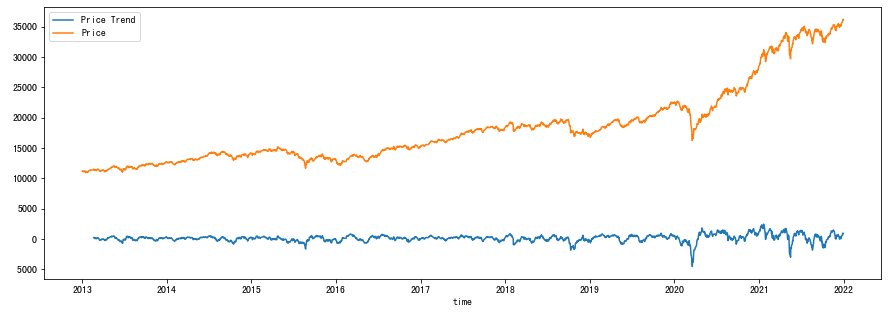

In [23]:
fig = plt.figure(figsize=(15,5))
ax = plt.axes()

# for i in label.index:
ax.plot(pd.to_datetime(df_3.Date), df_3['price_trend'], label='Price Trend')
ax.plot(pd.to_datetime(df_3.Date), df_3['close_adj'], label='Price')

ax.set_xlabel('time')  # Add an x-label to the axes.
# ax.set_ylabel('price')  # Add a y-label to the axes.
ax.legend();  # Add a legend.

In [24]:
df_4 = copy.copy(df_3)
df_4 = df_4.dropna(axis=0)

In [30]:
num = len(df_4.columns)

def nor(lis):
    lis = lis.astype(float)
    lis = (np.array(lis) - np.nanmean(lis)) / (np.nanvar(lis))**(1/2)
    return lis

for i in df_4.columns[ list(range(1, 10))+list(range(14, num)) ]:
    try:
        df_4[i] = nor(df_4[i])
    except:
        print(i)
        continue

clf1 = RandomForestClassifier()
clf5 = RandomForestClassifier()
clf10 = RandomForestClassifier()
clf15 = RandomForestClassifier()
clf20 = RandomForestClassifier()

for year in range(2014, 2022):
    
    split = df_4[df_4['年月日'] < str(year)+'/01/01'].shape[0] # 3210
    start = df_4[df_4['年月日'] < str(year-1)+'/01/01'].shape[0] # 3210
    end = df_4[df_4['年月日'] < str(year+1)+'/01/01'].shape[0] 
    
    for delay in [1, 5, 10, 15, 20]:
        
        if delay == 1:
            clf = clf1
        elif delay == 5:
            clf = clf5
        elif delay == 10:
            clf = clf10
        elif delay == 15:
            clf = clf15
        elif delay == 20:
            clf = clf20
            

        X_train = df_4.iloc[start:split-delay, list(range(1, 10))+list(range(14, num))].values
        y_train = df_4.iloc[start+delay:split, 12].values
        X_test = df_4.iloc[split-delay:end-delay, list(range(1, 10))+list(range(14, num))].values
        y_test = df_4.iloc[split:end, 12].values

        print('\n', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
#         print('\n')

        accuracy_list = []

        for epoch in range(10):
            clf.fit(X_train, y_train)
            y_predict = clf.predict(X_test)
            confusionMatrix = confusion_matrix(y_test, y_predict)
#             print(confusionMatrix)
            accuracy = (confusionMatrix[0, 0]+confusionMatrix [1,1])/sum(sum(confusionMatrix))
    #         print(accuracy)
            accuracy_list.append(accuracy)
        print('Year: ', year, 'Delay: ', delay, 'Average Accuracy: ', sum(accuracy_list)/len(accuracy_list))


 (216, 27) (216,) (248, 27) (248,)
Year:  2014 Delay:  1 Average Accuracy:  0.8584677419354841

 (212, 27) (212,) (248, 27) (248,)
Year:  2014 Delay:  5 Average Accuracy:  0.8588709677419357

 (207, 27) (207,) (248, 27) (248,)
Year:  2014 Delay:  10 Average Accuracy:  0.8544354838709678

 (202, 27) (202,) (248, 27) (248,)
Year:  2014 Delay:  15 Average Accuracy:  0.7435483870967742

 (197, 27) (197,) (248, 27) (248,)
Year:  2014 Delay:  20 Average Accuracy:  0.6584677419354839

 (247, 27) (247,) (244, 27) (244,)
Year:  2015 Delay:  1 Average Accuracy:  0.3155737704918033

 (243, 27) (243,) (244, 27) (244,)
Year:  2015 Delay:  5 Average Accuracy:  0.3155737704918033

 (238, 27) (238,) (244, 27) (244,)
Year:  2015 Delay:  10 Average Accuracy:  0.3155737704918033

 (233, 27) (233,) (244, 27) (244,)
Year:  2015 Delay:  15 Average Accuracy:  0.3155737704918033

 (228, 27) (228,) (244, 27) (244,)
Year:  2015 Delay:  20 Average Accuracy:  0.3155737704918033

 (243, 27) (243,) (244, 27) (244,

## 加入其他因子溢酬資料

In [25]:
def extractPremium(name):
    Premium = pd.read_csv('./index_data/'+name+'_Premium.csv')
    Premium.columns = ['年月日', 'HighGroup', 'LowGroup']
    Premium[name+'_Premium'] = Premium.apply(lambda x: x[1]-x[2], axis=1)
    Premium['年月日'] = [i[0:4]+'/'+i[5:7]+'/'+i[8:10] for i in Premium['年月日']]
    return Premium

CTP_Premium = extractPremium('CTP')
EB_Premium = extractPremium('EB')
EP_Premium = extractPremium('EP')
VOL_Premium = extractPremium('VOL')
MOM_Premium = extractPremium('MOM')
SEN_Premium = extractPremium('SEN')
HEAT_Premium = extractPremium('HEAT')
WB_Premium = extractPremium('WB')

In [26]:
df_4 = df_4.merge(CTP_Premium[['年月日', 'CTP_Premium']], on='年月日')
df_4 = df_4.merge(EB_Premium[['年月日', 'EB_Premium']], on='年月日')
df_4 = df_4.merge(EP_Premium[['年月日', 'EP_Premium']], on='年月日')
df_4 = df_4.merge(VOL_Premium[['年月日', 'VOL_Premium']], on='年月日')
df_4 = df_4.merge(MOM_Premium[['年月日', 'MOM_Premium']], on='年月日')
df_4 = df_4.merge(SEN_Premium[['年月日', 'SEN_Premium']], on='年月日')
df_4 = df_4.merge(HEAT_Premium[['年月日', 'HEAT_Premium']], on='年月日')
df_4 = df_4.merge(WB_Premium[['年月日', 'WB_Premium']], on='年月日')

In [27]:
df_4.columns

Index(['年月日', '融資餘額(張)', '融資餘額(千元)', '融券餘額(張)', '融券餘額(千元)', '借券賣出餘額(張)',
       '借券賣出餘額(千元)', '借券賣出可使用額度', '借券賣出限額', '券資比', 'Date', 'close_adj', 'bb',
       '年月', 'EA1101 台灣-景氣對策信號綜合分數-月(分數)', 'EB0308 台灣-原物料價格指數-月(指數)',
       'EB0311 台灣-進口原物料數量指數-月(指數)', 'EB0312 台灣-未來六個月的景氣狀況指數-月(指數)',
       'EB18 台灣-消費者信心指數-月(指數)', 'EB23 台灣-消費者信心指數-未來半年投資股票時機-月(指數)',
       'EC03 台灣-平均薪資-製造業(經季節調整)-台幣-月(元)(TWD)', 'EC08 台灣股價指數變動率-月均值(百分比)',
       'LA07 台灣-失業率-月(百分比)', 'LA0702 台灣-失業率(經季節調整)-月(百分比)',
       'MA1601 台灣-貨幣總計數-M2年增率-期底-月(百分比)', 'PA0110 台灣-CPI總指數(2016=100)-月(指數)',
       'PA0118 台灣-CPI-總指數(經季節調整)(2016=100)-月(指數)', 'Trend', 'Heat', 'Trend2',
       'Heat2', 'price_trend', 'CTP_Premium', 'EB_Premium', 'EP_Premium',
       'VOL_Premium', 'MOM_Premium', 'SEN_Premium', 'HEAT_Premium',
       'WB_Premium'],
      dtype='object')

# 以年預測，初版Random Forest

In [29]:
num = len(df_4.columns)

def nor(lis):
    lis = lis.astype(float)
    lis = (np.array(lis) - np.nanmean(lis)) / (np.nanvar(lis))**(1/2)
    return lis

for i in df_4.columns[ list(range(1, 10))+list(range(14, num)) ]:
    try:
        df_4[i] = nor(df_4[i])
    except:
        print(i)
        continue

clf1 = RandomForestClassifier()
clf5 = RandomForestClassifier()
clf10 = RandomForestClassifier()
clf15 = RandomForestClassifier()
clf20 = RandomForestClassifier()

for year in range(2014, 2022):
    
    split = df_4[df_4['年月日'] < str(year)+'/01/01'].shape[0] # 3210
    start = df_4[df_4['年月日'] < str(year-1)+'/01/01'].shape[0] # 3210
    end = df_4[df_4['年月日'] < str(year+1)+'/01/01'].shape[0] 
    
    for delay in [1, 5, 10, 15, 20]:
        
        if delay == 1:
            clf = clf1
        elif delay == 5:
            clf = clf5
        elif delay == 10:
            clf = clf10
        elif delay == 15:
            clf = clf15
        elif delay == 20:
            clf = clf20
            

        X_train = df_4.iloc[start:split-delay, list(range(1, 10))+list(range(14, num))].values
        y_train = df_4.iloc[start+delay:split, 12].values
        X_test = df_4.iloc[split-delay:end-delay, list(range(1, 10))+list(range(14, num))].values
        y_test = df_4.iloc[split:end, 12].values

        print('\n', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
#         print('\n')

        accuracy_list = []

        for epoch in range(10):
            clf.fit(X_train, y_train)
            y_predict = clf.predict(X_test)
            confusionMatrix = confusion_matrix(y_test, y_predict)
#             print(confusionMatrix)
            accuracy = (confusionMatrix[0, 0]+confusionMatrix [1,1])/sum(sum(confusionMatrix))
    #         print(accuracy)
            accuracy_list.append(accuracy)
        print('Year: ', year, 'Delay: ', delay, 'Average Accuracy: ', sum(accuracy_list)/len(accuracy_list))


 (189, 35) (189,) (248, 35) (248,)
Year:  2014 Delay:  1 Average Accuracy:  0.8560483870967743

 (185, 35) (185,) (248, 35) (248,)
Year:  2014 Delay:  5 Average Accuracy:  0.8588709677419357

 (180, 35) (180,) (248, 35) (248,)
Year:  2014 Delay:  10 Average Accuracy:  0.8588709677419357

 (175, 35) (175,) (248, 35) (248,)
Year:  2014 Delay:  15 Average Accuracy:  0.804435483870968

 (170, 35) (170,) (248, 35) (248,)
Year:  2014 Delay:  20 Average Accuracy:  0.6637096774193548

 (247, 35) (247,) (244, 35) (244,)
Year:  2015 Delay:  1 Average Accuracy:  0.3155737704918033

 (243, 35) (243,) (244, 35) (244,)
Year:  2015 Delay:  5 Average Accuracy:  0.3155737704918033

 (238, 35) (238,) (244, 35) (244,)
Year:  2015 Delay:  10 Average Accuracy:  0.3155737704918033

 (233, 35) (233,) (244, 35) (244,)
Year:  2015 Delay:  15 Average Accuracy:  0.3155737704918033

 (228, 35) (228,) (244, 35) (244,)
Year:  2015 Delay:  20 Average Accuracy:  0.3155737704918033

 (243, 35) (243,) (244, 35) (244,)

In [30]:
df_4

,年月日,融資餘額(張),融資餘額(千元),融券餘額(張),融券餘額(千元),借券賣出餘額(張),借券賣出餘額(千元),借券賣出可使用額度,借券賣出限額,券資比,...,Heat2,price_trend,CTP_Premium,EB_Premium,EP_Premium,VOL_Premium,MOM_Premium,SEN_Premium,HEAT_Premium,WB_Premium
0,2013/04/01,1.030366,0.261821,-0.337011,0.003775,-2.120422,-1.083759,-0.680485,-2.212433,-0.632395,...,2.295852,-0.327467,-1.032175,0.978032,0.233541,0.499959,0.122047,-0.254342,1.024437,1.899970
1,2013/04/02,1.003042,0.240614,-0.515382,-0.243245,-2.119153,-1.071899,-0.689264,-2.213173,-0.728368,...,2.959359,-0.289064,-0.678259,0.399911,0.019050,0.026588,0.069556,-0.959447,0.164526,-0.721690
2,2013/04/03,1.001827,0.225995,-0.762170,-0.600707,-2.104955,-1.053937,-0.703294,-2.213812,-0.874105,...,2.928265,-0.209801,0.350798,0.625828,-0.299633,-0.227822,0.624820,1.713008,-0.630013,0.824522
3,2013/04/08,0.936129,0.174191,-1.216542,-1.129201,-2.094073,-1.071709,-0.699351,-2.213778,-1.130032,...,1.980417,-0.661622,-1.247929,1.272748,2.792095,-0.230914,0.510448,0.879247,0.121709,-0.385976
4,2013/04/09,0.888085,0.138255,-1.312451,-1.300934,-2.090665,-1.071485,-0.703920,-2.214537,-1.176241,...,2.400130,-0.703493,0.358786,-0.609561,-1.126343,0.454470,0.984726,0.094675,-0.471829,-0.782298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2145,2021/12/24,0.154960,2.621793,0.074098,2.290283,1.802938,3.225562,1.543880,2.217545,-0.131204,...,-0.373611,0.616101,-0.063072,0.063857,-0.867746,0.262406,0.649679,-0.079249,0.042876,-0.062225
2146,2021/12/27,0.170348,2.639397,0.073686,2.257867,1.806281,3.255286,1.494201,2.214069,-0.134759,...,-1.028392,0.864496,0.343925,0.357648,-0.571935,-0.849329,0.541063,0.299466,0.212059,-0.583216
2147,2021/12/28,0.152657,2.624305,0.058401,2.222013,1.794949,3.269798,1.442395,2.212280,-0.138313,...,-0.710201,1.309690,-0.273277,-0.176388,1.584487,-0.248496,0.483619,1.055150,0.158484,-0.028760
2148,2021/12/29,0.149354,2.631061,0.102960,2.281697,1.755921,3.230319,1.390694,2.291014,-0.109877,...,-0.673769,1.427682,0.265860,-0.317919,-0.243634,0.462144,-0.442109,0.020990,-0.235664,-0.380215


# 以年預測，初版Logistic Regression...


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix

num = len(df_4.columns)

def nor(lis):
    lis = lis.astype(float)
    lis = (np.array(lis) - np.nanmean(lis)) / (np.nanvar(lis))**(1/2)
    return lis

for i in df_4.columns[ list(range(1, 10))+list(range(14, num)) ]:
    try:
        df_4[i] = nor(df_4[i])
    except:
        print(i)
        continue


otherAI = GaussianNB()
otherAI = SVC()
otherAI = LogisticRegression()
        
clf1 = otherAI
clf5 = otherAI
clf10 = otherAI
clf15 = otherAI
clf20 = otherAI

for year in range(2014, 2022):
    
    split = df_4[df_4['年月日'] < str(year)+'/01/01'].shape[0] # 3210
    start = df_4[df_4['年月日'] < str(year-1)+'/01/01'].shape[0] # 3210
    end = df_4[df_4['年月日'] < str(year+1)+'/01/01'].shape[0] 
    
    for delay in [1, 5, 10, 15, 20]:
        
        if delay == 1:
            clf = clf1
        elif delay == 5:
            clf = clf5
        elif delay == 10:
            clf = clf10
        elif delay == 15:
            clf = clf15
        elif delay == 20:
            clf = clf20
            

        X_train = df_4.iloc[start:split-delay, list(range(1, 10))+list(range(14, num))].values
        y_train = df_4.iloc[start+delay:split, 12].values
        X_test = df_4.iloc[split-delay:end-delay, list(range(1, 10))+list(range(14, num))].values
        y_test = df_4.iloc[split:end, 12].values

        print('\n', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
#         print('\n')

        accuracy_list = []

        for epoch in range(10):
            clf.fit(X_train, y_train)
            y_predict = clf.predict(X_test)
            confusionMatrix = confusion_matrix(y_test, y_predict)
#             print(confusionMatrix)
            accuracy = (confusionMatrix[0, 0]+confusionMatrix [1,1])/sum(sum(confusionMatrix))
    #         print(accuracy)
            accuracy_list.append(accuracy)
        print('Year: ', year, 'Delay: ', delay, 'Average Accuracy: ', sum(accuracy_list)/len(accuracy_list))


 (189, 35) (189,) (248, 35) (248,)
Year:  2014 Delay:  1 Average Accuracy:  0.8588709677419357

 (185, 35) (185,) (248, 35) (248,)
Year:  2014 Delay:  5 Average Accuracy:  0.8588709677419357

 (180, 35) (180,) (248, 35) (248,)
Year:  2014 Delay:  10 Average Accuracy:  0.8588709677419357

 (175, 35) (175,) (248, 35) (248,)
Year:  2014 Delay:  15 Average Accuracy:  0.5806451612903227

 (170, 35) (170,) (248, 35) (248,)
Year:  2014 Delay:  20 Average Accuracy:  0.5685483870967741

 (247, 35) (247,) (244, 35) (244,)
Year:  2015 Delay:  1 Average Accuracy:  0.31147540983606564

 (243, 35) (243,) (244, 35) (244,)
Year:  2015 Delay:  5 Average Accuracy:  0.31147540983606564

 (238, 35) (238,) (244, 35) (244,)
Year:  2015 Delay:  10 Average Accuracy:  0.3155737704918033

 (233, 35) (233,) (244, 35) (244,)
Year:  2015 Delay:  15 Average Accuracy:  0.3155737704918033

 (228, 35) (228,) (244, 35) (244,)
Year:  2015 Delay:  20 Average Accuracy:  0.3155737704918033

 (243, 35) (243,) (244, 35) (24

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Year:  2021 Delay:  5 Average Accuracy:  0.9221311475409836

 (235, 35) (235,) (244, 35) (244,)
Year:  2021 Delay:  10 Average Accuracy:  0.8770491803278688

 (230, 35) (230,) (244, 35) (244,)
Year:  2021 Delay:  15 Average Accuracy:  0.4016393442622951

 (225, 35) (225,) (244, 35) (244,)
Year:  2021 Delay:  20 Average Accuracy:  0.36065573770491804


In [71]:
clf1.coef_

array([[ 0.10893416, -0.23263161, -0.93999691, -2.1862725 ,  0.84855967,
         0.05814662, -1.62441817,  0.0953209 , -1.20261055,  0.77345156,
         1.07071106, -0.34460249,  0.44606841,  0.1018785 ,  1.68403403,
        -0.41873339,  0.32301407,  0.23869891,  1.85887337,  1.3414616 ,
        -0.71180239, -0.00803005,  1.0888479 ,  0.46447084, -0.10673453,
         0.70881594,  0.76838129, -0.14529863, -0.21176106,  0.2154443 ,
        -0.05638875, -0.10353205, -0.21659032,  0.48572284, -0.04485376]])

In [98]:
stay_factor = []

from sklearn.feature_selection import f_regression
for i in range(len(f_regression(X_train, y_train)[1])):
    factor_name = df_4.iloc[start:split-delay, list(range(1, 10))+list(range(14, num))].columns[i]
    factor_pvalue = f_regression(X_train, y_train)[1][i]
    print(factor_name, factor_pvalue)
    if factor_pvalue <= 0.1:
        stay_factor.append(factor_name)
        
print(stay_factor)
# from sklearn.feature_selection import chi2
# print(chi2(X_train, y_train))

融資餘額(張) 0.0015917587832439083
融資餘額(千元) 0.019601422308624668
融券餘額(張) 0.021096749578755205
融券餘額(千元) 0.012224666794139057
借券賣出餘額(張) 1.4938020159962964e-08
借券賣出餘額(千元) 0.00047658504531682664
借券賣出可使用額度 0.871900912900603
借券賣出限額 0.23069601979440002
券資比 6.623721822498716e-05
EA1101 台灣-景氣對策信號綜合分數-月(分數) 0.01720371604747053
EB0308 台灣-原物料價格指數-月(指數) 0.5912008718782857
EB0311 台灣-進口原物料數量指數-月(指數) 0.14745526933147518
EB0312 台灣-未來六個月的景氣狀況指數-月(指數) 0.03709792368749935
EB18 台灣-消費者信心指數-月(指數) 4.65711624359635e-11
EB23 台灣-消費者信心指數-未來半年投資股票時機-月(指數) 3.055943912202899e-09
EC03 台灣-平均薪資-製造業(經季節調整)-台幣-月(元)(TWD) 0.26098922993801893
EC08 台灣股價指數變動率-月均值(百分比) 1.8206784910950744e-05
LA07 台灣-失業率-月(百分比) 4.5304790456209365e-08
LA0702 台灣-失業率(經季節調整)-月(百分比) 6.193113089294338e-06
MA1601 台灣-貨幣總計數-M2年增率-期底-月(百分比) 0.05328313718251052
PA0110 台灣-CPI總指數(2016=100)-月(指數) 0.0027581113003145763
PA0118 台灣-CPI-總指數(經季節調整)(2016=100)-月(指數) 5.201673336923729e-07
Trend 0.0034974084108564817
Heat 0.15279477568737285
Trend2 0.13950527859328682
Heat

# 看看使用sklearn.feature_selection 裡的 f_regression後的結果

In [109]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import statsmodels.api as sm

num = len(df_4.columns)

def nor(lis):
    lis = lis.astype(float)
    lis = (np.array(lis) - np.nanmean(lis)) / (np.nanvar(lis))**(1/2)
    return lis

for i in df_4.columns[ list(range(1, 10))+list(range(14, num)) ]:
    try:
        df_4[i] = nor(df_4[i])
    except:
        print(i)
        continue

clf1 = LogisticRegression()
clf5 = LogisticRegression()
clf10 = LogisticRegression()
clf15 = LogisticRegression()
clf20 = LogisticRegression()

for year in range(2014, 2022):
    
    split = df_4[df_4['年月日'] < str(year)+'/01/01'].shape[0] # 3210
    start = df_4[df_4['年月日'] < str(year-1)+'/01/01'].shape[0] # 3210
    end = df_4[df_4['年月日'] < str(year+1)+'/01/01'].shape[0] 
    
    for delay in [1, 5, 10, 15, 20]:
        
        if delay == 1:
            clf = clf1
        elif delay == 5:
            clf = clf5
        elif delay == 10:
            clf = clf10
        elif delay == 15:
            clf = clf15
        elif delay == 20:
            clf = clf20
            

        X_train = df_4.loc[start:split-delay-1, stay_factor].values # 多減1!!!
        y_train = df_4.iloc[start+delay:split, 12].values
        X_test = df_4.loc[split-delay:end-delay-1, stay_factor].values # 多減1!!!
        y_test = df_4.iloc[split:end, 12].values

        print('\n', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
#         print('\n')

        accuracy_list = []

        for epoch in range(10):
            clf.fit(X_train, y_train)
            y_predict = clf.predict(X_test)
            confusionMatrix = confusion_matrix(y_test, y_predict)
#             print(confusionMatrix)
            accuracy = (confusionMatrix[0, 0]+confusionMatrix [1,1])/sum(sum(confusionMatrix))
    #         print(accuracy)
            accuracy_list.append(accuracy)
        print('Year: ', year, 'Delay: ', delay, 'Average Accuracy: ', sum(accuracy_list)/len(accuracy_list))


 (189, 22) (189,) (248, 22) (248,)
Year:  2014 Delay:  1 Average Accuracy:  0.8540322580645162

 (185, 22) (185,) (248, 22) (248,)
Year:  2014 Delay:  5 Average Accuracy:  0.8588709677419357

 (180, 22) (180,) (248, 22) (248,)
Year:  2014 Delay:  10 Average Accuracy:  0.8326612903225807

 (175, 22) (175,) (248, 22) (248,)
Year:  2014 Delay:  15 Average Accuracy:  0.5479838709677419

 (170, 22) (170,) (248, 22) (248,)
Year:  2014 Delay:  20 Average Accuracy:  0.6189516129032258

 (247, 22) (247,) (244, 22) (244,)
Year:  2015 Delay:  1 Average Accuracy:  0.3155737704918033

 (243, 22) (243,) (244, 22) (244,)
Year:  2015 Delay:  5 Average Accuracy:  0.3155737704918033

 (238, 22) (238,) (244, 22) (244,)
Year:  2015 Delay:  10 Average Accuracy:  0.3155737704918033

 (233, 22) (233,) (244, 22) (244,)
Year:  2015 Delay:  15 Average Accuracy:  0.3155737704918033

 (228, 22) (228,) (244, 22) (244,)
Year:  2015 Delay:  20 Average Accuracy:  0.3155737704918033

 (243, 22) (243,) (244, 22) (244,

# 以季去train，效果更好！

## 被遺棄的

In [43]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
import time

num = len(df_4.columns)

def nor(lis):
    lis = lis.astype(float)
    lis = (np.array(lis) - np.nanmean(lis)) / (np.nanvar(lis))**(1/2)
    return lis

for i in df_4.columns[ list(range(1, 10))+list(range(14, num)) ]:
    try:
        df_4[i] = nor(df_4[i])
    except:
        print(i)
        continue

clf1 = RandomForestClassifier()
clf5 = RandomForestClassifier()
clf10 = RandomForestClassifier()
clf15 = RandomForestClassifier()
clf20 = RandomForestClassifier()

BBPredict = pd.DataFrame(index=df_4.Date, columns=['PredictLabel'])

for year in range(2014, 2022):
# for year in range(2014, 2015):
    for month in [4, 6, 9, 12]: # 3, 5, 8, 11 -> 4, 6, 9, 12
        split = start = end = 0
        if month == 4:
            split = df_4[df_4['年月日'] < str(year)+'/04/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-1)+'/12/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0]
        elif month == 6:
            split = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year)+'/04/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0]
        elif month == 9:
            split = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0]
        elif month == 12:
            split = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year+1)+'/04/01'].shape[0]
    
        for delay in [1, 5, 10, 15, 20]:
#         for delay in [1]:

            if delay == 1:
                clf = clf1
            elif delay == 5:
                clf = clf5
            elif delay == 10:
                clf = clf10
            elif delay == 15:
                clf = clf15
            elif delay == 20:
                clf = clf20

            sel = SelectFromModel(clf)

            X_train = df_4.iloc[start:split-delay, list(range(1, 10))+list(range(14, num))].values
            y_train = df_4.iloc[start+delay:split, 12].values
            X_test = df_4.iloc[split-delay:end-delay, list(range(1, 10))+list(range(14, num))].values
            y_test = df_4.iloc[split:end, 12].values

            print('\n', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    #         print('\n')

            accuracy_list = []

            for epoch in range(10):
#                 sel.fit(X_train, y_train)
#                 X_train_new = sel.transform(X_train)
#                 clf.fit(X_train_new, y_train)
#                 X_test_new = sel.transform(X_test)
#                 y_predict = clf.predict(X_test_new)
                
                X_train_new = copy.copy(X_train)
                clf.fit(X_train_new, y_train)
                X_test_new = copy.copy(X_test)
                y_predict = clf.predict(X_test_new)

    #             sel.fit(X_train, y_train)
    #             X_train = sel.transform(X_train)
    #             clf.fit(X_train, y_train)
    #             X_test = sel.transform(X_test)
    #             y_predict = clf.predict(X_test)

    #             y_predict = clf.predict_proba(X_test_new)
    #             thres = 0.75
    #             y_cut = (y_predict[:,0] > thres) | (y_predict [:,1] > thres) # cut y value and leave the better result
    #             predictions_2 = np.argmax(y_predict[y_cut], axis=-1)
    #             confusionMatrix = confusion_matrix(y_test[y_cut], predictions_2)

                confusionMatrix = confusion_matrix(y_test, y_predict)
    #             print(confusionMatrix)
                try:
                    accuracy = (confusionMatrix[0, 0]+confusionMatrix [1,1])/sum(sum(confusionMatrix))
                except:
                    print('continue', end=' ')
                    continue
    #             print(accuracy, end=' ')
                accuracy_list.append(accuracy)
            if len(accuracy_list) > 0:
                print('Year: ', year, 'Month: ', month, 'Delay: ', delay, 'Average Accuracy: ', sum(accuracy_list)/len(accuracy_list))
            
            for date_index in range(len(df_4.iloc[split:end, 0])):
                if len(clf.predict_proba(X_test_new)[date_index]) == 2:
                    BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'] = np.append(BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'], str(clf.predict_proba(X_test_new)[date_index][1]))
                else:
                    BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'] = np.append(BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'], str(clf.predict_proba(X_test_new)[date_index][0]))
                    
        print(clf1.feature_importances_)
        print(clf5.feature_importances_)
        print(clf10.feature_importances_)
        print(clf15.feature_importances_)
        print(clf20.feature_importances_)


 (77, 35) (77,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  1 Average Accuracy:  0.9285714285714286

 (73, 35) (73,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  5 Average Accuracy:  0.9285714285714286

 (68, 35) (68,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  10 Average Accuracy:  0.9285714285714286

 (63, 35) (63,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  15 Average Accuracy:  0.9285714285714286

 (58, 35) (58,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  20 Average Accuracy:  0.9285714285714286
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 


 (20, 35) (20,) (64, 35) (64,)
Year:  2015 Month:  6 Delay:  20 Average Accuracy:  0.921875
[0.01972035 0.00646513 0.17196086 0.114662   0.13883781 0.0552612
 0.13671075 0.         0.10177728 0.01324675 0.01321975 0.0302963
 0.02537862 0.00813397 0.03699177 0.02691762 0.00814286 0.01924948
 0.         0.02047807 0.02428771 0.00924138 0.00030226 0.
 0.00393489 0.         0.00186603 0.00082105 0.00069519 0.00663774
 0.         0.00185714 0.         0.         0.00290603]
[0.00305556 0.         0.16658138 0.07513498 0.20300966 0.02122533
 0.11699287 0.01252104 0.10279278 0.0152202  0.02223134 0.01032494
 0.01035172 0.01387731 0.00928476 0.00752745 0.01730137 0.00636842
 0.         0.02284031 0.01337121 0.00266667 0.0205888  0.00390756
 0.00628472 0.02699357 0.01979526 0.00437879 0.00189324 0.01028204
 0.02242201 0.01094216 0.00622709 0.0028822  0.01072325]
[0.02750265 0.02576977 0.0517488  0.13470799 0.17960463 0.17329345
 0.08594372 0.03676331 0.09874572 0.         0.00252153 0.00428571

[5.99600126e-02 4.70593174e-02 6.35278191e-02 3.86758646e-02
 2.56377588e-01 6.03156061e-02 8.39268026e-02 2.88191195e-02
 4.51585809e-02 5.09599093e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.29276896e-04 0.00000000e+00
 1.59154571e-03 2.91416624e-03 7.69736842e-04 7.06521739e-04
 1.19424603e-03 7.06521739e-04 9.87478646e-02 1.71355969e-02
 6.82672352e-02 7.38008818e-03 1.35672334e-02 2.49815360e-02
 8.14276071e-03 8.98617071e-03 1.71313960e-02 1.27156200e-02
 1.37852748e-02 7.74212168e-03 4.38838519e-03]
[6.87286854e-02 1.18738280e-01 1.07379948e-01 8.47485834e-02
 4.42366900e-02 2.45902879e-02 9.86644102e-02 1.05164698e-02
 8.20128339e-02 9.53010497e-03 7.01704545e-03 1.59796731e-02
 5.30303030e-04 1.24536723e-02 4.35729847e-03 6.38157895e-03
 4.31154684e-03 4.11184211e-05 0.00000000e+00 3.93939394e-03
 5.12432509e-03 6.75647620e-03 1.16351240e-01 9.12129625e-03
 4.02193643e-02 1.18200471e-02 3.97830028e-03 9.51033030e-03
 1.10800502e-02 1.54126975e-02 9.33518

KeyboardInterrupt: 

In [30]:
feature_names = list(df_4.columns[list(range(1, 10))+list(range(14, num))])
# feature_names

## 改良版的

In [166]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
import time

num = len(df_4.columns)

def nor(lis):
    lis = lis.astype(float)
    lis = (np.array(lis) - np.nanmean(lis)) / (np.nanvar(lis))**(1/2)
    return lis

for i in df_4.columns[ list(range(1, 10))+list(range(14, num)) ]:
    try:
        df_4[i] = nor(df_4[i])
    except:
        print(i)
        continue

clf1 = RandomForestClassifier(n_estimators=100)
clf5 = RandomForestClassifier(n_estimators=100)
clf10 = RandomForestClassifier(n_estimators=100)
clf15 = RandomForestClassifier(n_estimators=100)
clf20 = RandomForestClassifier(n_estimators=100)
clf30 = RandomForestClassifier(n_estimators=100)
clf60 = RandomForestClassifier(n_estimators=100)
clf90 = RandomForestClassifier(n_estimators=100)

BBPredict = pd.DataFrame(index=df_4.Date, columns=['PredictLabel'])

for year in range(2014, 2022):
# for year in range(2014, 2015):
    for month in [4, 6, 9, 12]: # 3, 5, 8, 11 -> 4, 6, 9, 12
        split = start = end = 0
        if month == 4:
            split = df_4[df_4['年月日'] < str(year)+'/04/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-1)+'/12/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0]
        elif month == 6:
            split = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year)+'/04/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0]
        elif month == 9:
            split = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0]
        elif month == 12:
            split = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year+1)+'/04/01'].shape[0]
        
        start -= 150 ############## start earlier ##############
    
        for delay in [1, 5, 10, 15, 20, 30, 60 ,90]:
#         for delay in [1, 5, 10, 15, 20]:
#         for delay in [1]:

            if delay == 1:
                clf = clf1
            elif delay == 5:
                clf = clf5
            elif delay == 10:
                clf = clf10
            elif delay == 15:
                clf = clf15
            elif delay == 20:
                clf = clf20
            elif delay == 30:
                clf = clf30
            elif delay == 60:
                clf = clf60
            elif delay == 90:
                clf = clf90

            sel = SelectFromModel(clf)
            
#             start = 0 ############## start from the very beginning ##############

            X_train = df_4.iloc[start:split-delay, list(range(1, 10))+list(range(14, num))].values
            y_train = df_4.iloc[start+delay:split, 12].values
            X_test = df_4.iloc[split-delay:end-delay, list(range(1, 10))+list(range(14, num))].values
            y_test = df_4.iloc[split:end, 12].values

            print('\n', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    #         print('\n')

            accuracy_list = []

            for epoch in range(10):
#                 sel.fit(X_train, y_train)
#                 X_train_new = sel.transform(X_train)
#                 clf.fit(X_train_new, y_train)
#                 X_test_new = sel.transform(X_test)
#                 y_predict = clf.predict(X_test_new)
                
                X_train_new = copy.copy(X_train)
                clf.fit(X_train_new, y_train)
                X_test_new = copy.copy(X_test)
                y_predict = clf.predict(X_test_new)


    #             y_predict = clf.predict_proba(X_test_new)
    #             thres = 0.75
    #             y_cut = (y_predict[:,0] > thres) | (y_predict [:,1] > thres) # cut y value and leave the better result
    #             predictions_2 = np.argmax(y_predict[y_cut], axis=-1)
    #             confusionMatrix = confusion_matrix(y_test[y_cut], predictions_2)
                confusionMatrix = confusion_matrix(y_test, y_predict)
#                 print(confusionMatrix)
                try:
                    accuracy = (confusionMatrix[0, 0]+confusionMatrix [1,1])/sum(sum(confusionMatrix))
                except:
#                     print('continue', end=' ')
#                     continue
                    accuracy = 1.0
    #             print(accuracy, end=' ')
                accuracy_list.append(accuracy)
            if len(accuracy_list) > 0:
                print('Year: ', year, 'Month: ', month, 'Delay: ', delay, 'Bull Percentage: ', sum(y_test)/len(y_test), 'Average Accuracy: ', sum(accuracy_list)/len(accuracy_list))
            
            for date_index in range(len(df_4.iloc[split:end, 0])):
                if len(clf.predict_proba(X_test_new)[date_index]) == 2:
                    BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'] = np.append(BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'], str(clf.predict_proba(X_test_new)[date_index][1]))
                else:
                    BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'] = np.append(BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'], str(clf.predict_proba(X_test_new)[date_index][0]))

#             print(y_test, y_predict)
#             print(confusionMatrix)
#             print(clf.feature_importances_)
            


 (227, 35) (227,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  1 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (223, 35) (223,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  5 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (218, 35) (218,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  10 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (213, 35) (213,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  15 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (208, 35) (208,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  20 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.569047619047619

 (198, 35) (198,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  30 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.8333333333333334

 (168, 35) (168,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  60 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (138, 3


 (220, 35) (220,) (40, 35) (40,)
Year:  2016 Month:  4 Delay:  10 Bull Percentage:  0.525 Average Accuracy:  0.5250000000000001

 (215, 35) (215,) (40, 35) (40,)
Year:  2016 Month:  4 Delay:  15 Bull Percentage:  0.525 Average Accuracy:  0.5250000000000001

 (210, 35) (210,) (40, 35) (40,)
Year:  2016 Month:  4 Delay:  20 Bull Percentage:  0.525 Average Accuracy:  0.5250000000000001

 (200, 35) (200,) (40, 35) (40,)
Year:  2016 Month:  4 Delay:  30 Bull Percentage:  0.525 Average Accuracy:  0.47250000000000003

 (170, 35) (170,) (40, 35) (40,)
Year:  2016 Month:  4 Delay:  60 Bull Percentage:  0.525 Average Accuracy:  0.5250000000000001

 (140, 35) (140,) (40, 35) (40,)
Year:  2016 Month:  4 Delay:  90 Bull Percentage:  0.525 Average Accuracy:  0.49749999999999994

 (189, 35) (189,) (64, 35) (64,)
Year:  2016 Month:  6 Delay:  1 Bull Percentage:  1.0 Average Accuracy:  0.9171875

 (185, 35) (185,) (64, 35) (64,)
Year:  2016 Month:  6 Delay:  5 Bull Percentage:  1.0 Average Accuracy:  


 (224, 35) (224,) (40, 35) (40,)
Year:  2018 Month:  4 Delay:  5 Bull Percentage:  0.6 Average Accuracy:  0.7249999999999999

 (219, 35) (219,) (40, 35) (40,)
Year:  2018 Month:  4 Delay:  10 Bull Percentage:  0.6 Average Accuracy:  0.8149999999999998

 (214, 35) (214,) (40, 35) (40,)
Year:  2018 Month:  4 Delay:  15 Bull Percentage:  0.6 Average Accuracy:  0.9299999999999999

 (209, 35) (209,) (40, 35) (40,)
Year:  2018 Month:  4 Delay:  20 Bull Percentage:  0.6 Average Accuracy:  0.7174999999999999

 (199, 35) (199,) (40, 35) (40,)
Year:  2018 Month:  4 Delay:  30 Bull Percentage:  0.6 Average Accuracy:  0.745

 (169, 35) (169,) (40, 35) (40,)
Year:  2018 Month:  4 Delay:  60 Bull Percentage:  0.6 Average Accuracy:  0.34500000000000003

 (139, 35) (139,) (40, 35) (40,)
Year:  2018 Month:  4 Delay:  90 Bull Percentage:  0.6 Average Accuracy:  0.40499999999999997

 (189, 35) (189,) (65, 35) (65,)
Year:  2018 Month:  6 Delay:  1 Bull Percentage:  0.07692307692307693 Average Accuracy:  


 (121, 35) (121,) (78, 35) (78,)
Year:  2019 Month:  12 Delay:  90 Bull Percentage:  0.7051282051282052 Average Accuracy:  0.7051282051282052

 (227, 35) (227,) (40, 35) (40,)
Year:  2020 Month:  4 Delay:  1 Bull Percentage:  1.0 Average Accuracy:  0.6475

 (223, 35) (223,) (40, 35) (40,)
Year:  2020 Month:  4 Delay:  5 Bull Percentage:  1.0 Average Accuracy:  0.8400000000000001

 (218, 35) (218,) (40, 35) (40,)
Year:  2020 Month:  4 Delay:  10 Bull Percentage:  1.0 Average Accuracy:  0.9949999999999999

 (213, 35) (213,) (40, 35) (40,)
Year:  2020 Month:  4 Delay:  15 Bull Percentage:  1.0 Average Accuracy:  1.0

 (208, 35) (208,) (40, 35) (40,)
Year:  2020 Month:  4 Delay:  20 Bull Percentage:  1.0 Average Accuracy:  1.0

 (198, 35) (198,) (40, 35) (40,)
Year:  2020 Month:  4 Delay:  30 Bull Percentage:  1.0 Average Accuracy:  0.6775

 (168, 35) (168,) (40, 35) (40,)
Year:  2020 Month:  4 Delay:  60 Bull Percentage:  1.0 Average Accuracy:  1.0

 (138, 35) (138,) (40, 35) (40,)
Year:

In [39]:
# https://hoishing.medium.com/using-chinese-characters-in-matplotlib-5c49dbb6a2f7
import matplotlib
print(matplotlib.matplotlib_fname())
import matplotlib.font_manager
# matplotlib.font_manager._rebuild()
[f for f in matplotlib.font_manager.fontManager.ttflist if 'Heiti' in f.name]
matplotlib.rcParams['font.family'] = ['Heiti TC']

/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc


# Random Forest中每個feature的重要性

<BarContainer object of 35 artists>

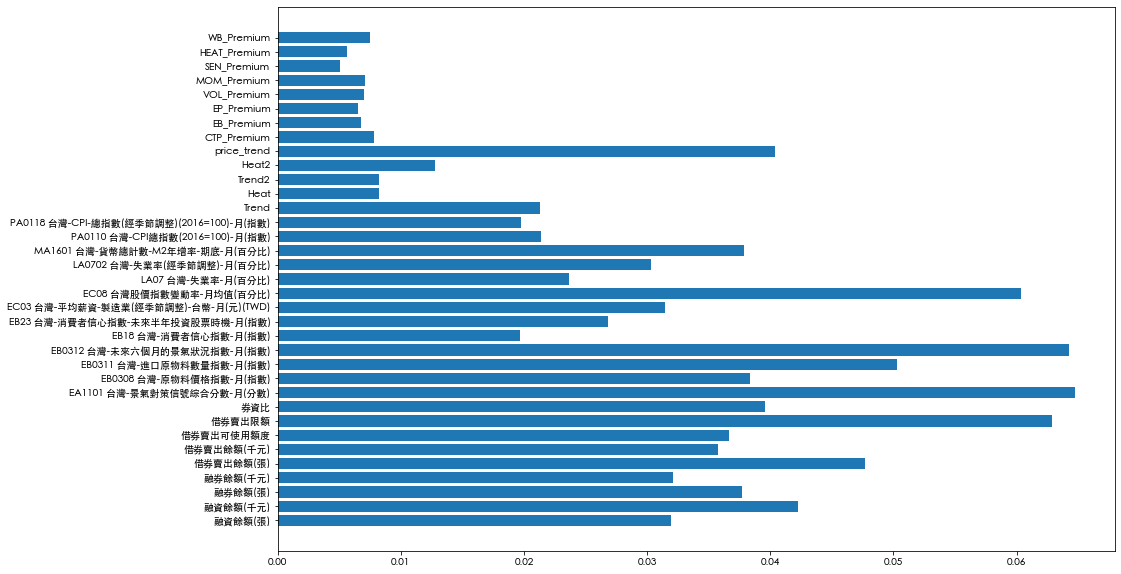

In [44]:
num = len(df_4.columns)

delay = 1
X = df_4.iloc[:-delay, list(range(1, 10))+list(range(14, num))].values
y = df_4.iloc[delay:, 12].values
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X, y)
plt.figure(figsize=(15,10))
plt.barh(feature_names, clf.feature_importances_)

In [167]:
BBPredict.to_csv('BBPredict.csv')

# 使用RFECV篩選Random Forest

In [118]:
from sklearn.feature_selection import RFECV

num = len(df_4.columns)

def nor(lis):
    lis = lis.astype(float)
    lis = (np.array(lis) - np.nanmean(lis)) / (np.nanvar(lis))**(1/2)
    return lis

for i in df_4.columns[ list(range(1, 10))+list(range(14, num)) ]:
    try:
        df_4[i] = nor(df_4[i])
    except:
        print(i)
        continue

clf1 = RandomForestClassifier()
clf5 = RandomForestClassifier()
clf10 = RandomForestClassifier()
clf15 = RandomForestClassifier()
clf20 = RandomForestClassifier()

for year in range(2014, 2022):
    
    split = df_4[df_4['年月日'] < str(year)+'/01/01'].shape[0] # 3210
    start = df_4[df_4['年月日'] < str(year-1)+'/01/01'].shape[0] # 3210
    end = df_4[df_4['年月日'] < str(year+1)+'/01/01'].shape[0] 
    
    for delay in [1, 5, 10, 15, 20]:
        
        if delay == 1:
            clf = clf1
        elif delay == 5:
            clf = clf5
        elif delay == 10:
            clf = clf10
        elif delay == 15:
            clf = clf15
        elif delay == 20:
            clf = clf20
            
#         sel = SelectFromModel(clf)
        sel = RFECV(clf, cv=5)


        X_train = df_4.iloc[start:split-delay, list(range(1, 10))+list(range(14, num))].values
        y_train = df_4.iloc[start+delay:split, 12].values
        X_test = df_4.iloc[split-delay:end-delay, list(range(1, 10))+list(range(14, num))].values
        y_test = df_4.iloc[split:end, 12].values

        print('\n', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
#         print('\n')

        accuracy_list = []

        for epoch in range(5):
            sel.fit(X_train, y_train)
            X_train_new = sel.transform(X_train)
            clf.fit(X_train_new, y_train)
            X_test_new = sel.transform(X_test)
            y_predict = clf.predict(X_test_new)
            
            confusionMatrix = confusion_matrix(y_test, y_predict)
#             print(confusionMatrix)
            accuracy = (confusionMatrix[0, 0]+confusionMatrix [1,1])/sum(sum(confusionMatrix))
    #         print(accuracy)
            accuracy_list.append(accuracy)
        print('Year: ', year, 'Delay: ', delay, 'Average Accuracy: ', sum(accuracy_list)/len(accuracy_list))


 (189, 35) (189,) (248, 35) (248,)
Year:  2014 Delay:  1 Average Accuracy:  0.8524193548387096

 (185, 35) (185,) (248, 35) (248,)
Year:  2014 Delay:  5 Average Accuracy:  0.8129032258064516

 (180, 35) (180,) (248, 35) (248,)
Year:  2014 Delay:  10 Average Accuracy:  0.8266129032258064

 (175, 35) (175,) (248, 35) (248,)
Year:  2014 Delay:  15 Average Accuracy:  0.7903225806451613

 (170, 35) (170,) (248, 35) (248,)
Year:  2014 Delay:  20 Average Accuracy:  0.6548387096774194

 (247, 35) (247,) (244, 35) (244,)
Year:  2015 Delay:  1 Average Accuracy:  0.31393442622950823

 (243, 35) (243,) (244, 35) (244,)
Year:  2015 Delay:  5 Average Accuracy:  0.31311475409836065

 (238, 35) (238,) (244, 35) (244,)
Year:  2015 Delay:  10 Average Accuracy:  0.3155737704918033

 (233, 35) (233,) (244, 35) (244,)
Year:  2015 Delay:  15 Average Accuracy:  0.3155737704918033

 (228, 35) (228,) (244, 35) (244,)
Year:  2015 Delay:  20 Average Accuracy:  0.3147540983606557

 (243, 35) (243,) (244, 35) (24